In [202]:
from typing import Optional, Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.preprocessing import normalize
import seaborn as sns

In [2]:
# plt.xkcd()
plt.rcdefaults()
plt.style.use("ggplot")

In [3]:
non_zero = pd.read_csv('data/hg19/matrix.mtx', sep=' ', skiprows=2,
                       names=('gene_id', 'cell_id', 'counts'))
shape = tuple(non_zero.iloc[0])[:2][::-1]
non_zero.drop(0, inplace=True)
genes = pd.read_csv('data/hg19/genes.tsv', sep='\t', names=('long', 'name'))

In [4]:
non_zero.gene_id -= 1
non_zero.cell_id -= 1

In [5]:
print(non_zero.max())

gene_id    32732
cell_id     2699
counts       419
dtype: int64


In [6]:
adata = sparse.csc_matrix((non_zero.counts, (non_zero.cell_id, non_zero.gene_id)),
                          dtype=np.int16, shape=shape)

In [7]:
adata.shape

(2700, 32738)

In [8]:
adata_norm = normalize(adata, norm='l1', axis=1)
total_count = np.array(adata_norm.sum(axis=0)).flatten()

In [9]:
total_count.shape

(32738,)

In [10]:
temp_ind = np.argpartition(total_count, -20)[-20:]
ind = temp_ind[np.argsort(total_count[temp_ind])]

In [11]:
ind

array([11887,  1989, 24087, 32022, 11447, 26912, 19420,   492,  5521,
       18998, 10709, 15745, 24673, 30933, 30970, 26013, 14247, 23794,
       13302, 19154])

<AxesSubplot:>

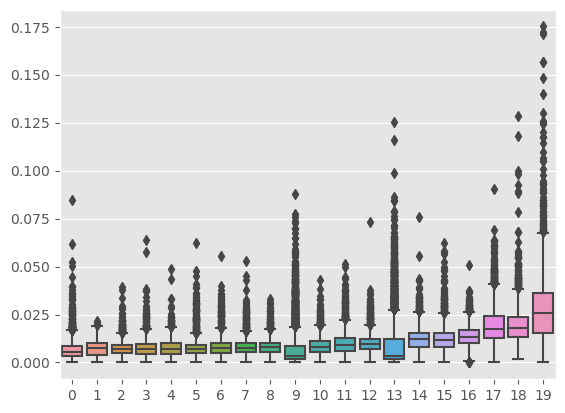

In [12]:
sns.boxplot(data=adata_norm[:,ind].toarray())

In [13]:
df = pd.DataFrame.sparse.from_spmatrix(adata, columns=genes.name)

In [14]:
# (np.array((adata != 0).sum(axis=1)).flatten() < 200).sum()
# (np.array((adata != 0).sum(axis=0)).flatten() < 3).sum()

In [15]:
cell_filter = (df != 0).sum(axis=1) >= 200
gene_filter = (df != 0).sum(axis=0) >= 3

In [16]:
df_filtered = df.loc[cell_filter, gene_filter]
mt_filter = df_filtered.columns.str.startswith('MT-')

In [17]:
gene_num_per_cell = (df_filtered != 0).sum(axis=1)
gene_counts_per_cell = df_filtered.sum(axis=1)
mt_pct = df_filtered.loc[:, mt_filter].sum(axis=1) / gene_counts_per_cell * 100

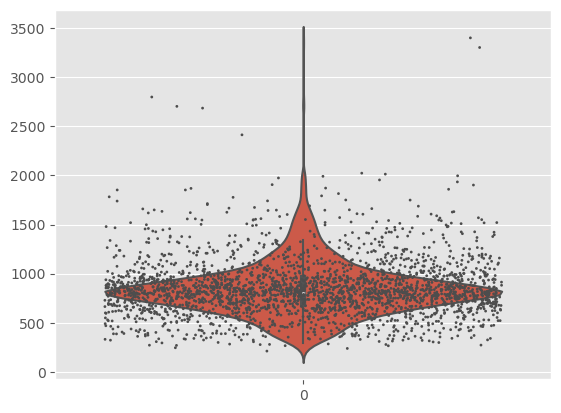

In [18]:
ax = sns.violinplot(data=gene_num_per_cell)
ax = sns.stripplot(data=gene_num_per_cell, jitter=0.4, size=2, color='.3')

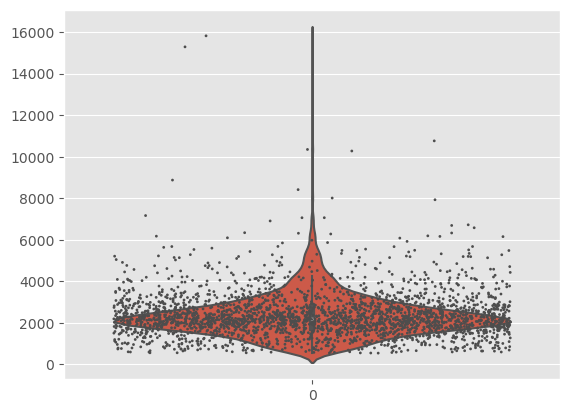

In [19]:
ax = sns.violinplot(data=gene_counts_per_cell)
ax = sns.stripplot(data=gene_counts_per_cell, jitter=0.4, size=2, color='.3')

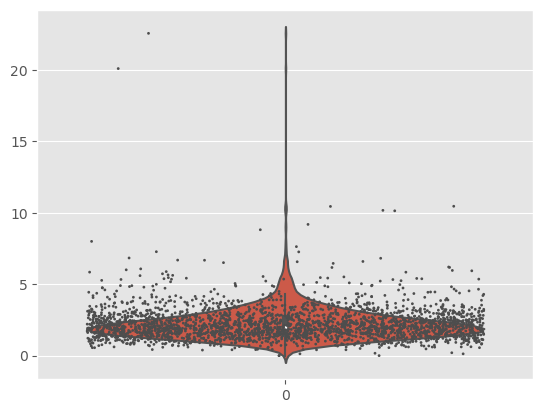

In [20]:
ax = sns.violinplot(data=mt_pct)
ax = sns.stripplot(data=mt_pct, jitter=0.4, size=2, color='.3')

In [21]:
temp_data = pd.DataFrame({'gene_counts_per_cell':gene_counts_per_cell,
                           'mt_pct':mt_pct, 
                           'gene_num_per_cell':gene_num_per_cell})

<AxesSubplot:xlabel='gene_counts_per_cell', ylabel='mt_pct'>

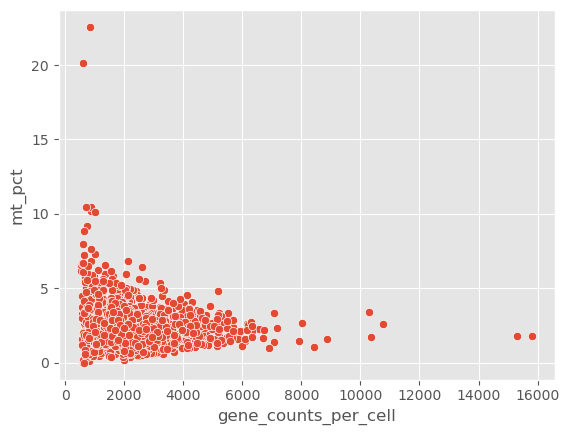

In [22]:
sns.scatterplot(data=temp_data, x='gene_counts_per_cell', y='mt_pct')

<AxesSubplot:xlabel='gene_counts_per_cell', ylabel='gene_num_per_cell'>

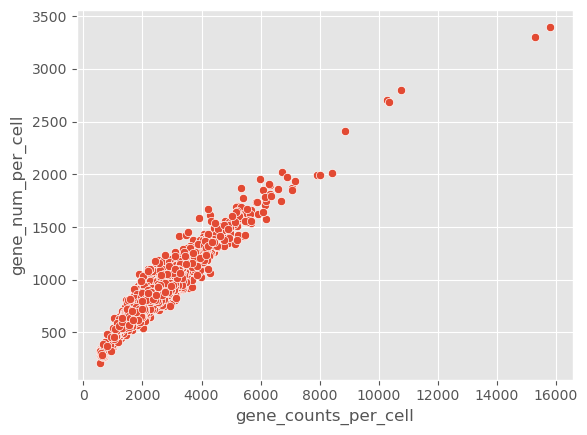

In [23]:
sns.scatterplot(data=temp_data, x='gene_counts_per_cell', y='gene_num_per_cell')

In [24]:
df_filtered_twice = df_filtered.loc[(gene_num_per_cell < 2500) & (mt_pct < 5)]

In [25]:
adata_filtered_twice = sparse.csr_matrix(df_filtered_twice)

In [26]:
adata_filtered_twice_norm = normalize(adata_filtered_twice, axis=1, norm='l1') * 1e4

In [27]:
adata_filtered_twice_norm_log1plus = adata_filtered_twice_norm.log1p()

In [211]:
adata_filtered_twice_norm_log1plus.mean()

0.12537256896020688

In [218]:
def my_get_mean_var(X, axis=0):
    if isinstance(X, sparse.spmatrix):  # same as sparse.issparse()
        mean, var = my_sparse_mean_variance_axis(X, axis=axis)
        var *= X.shape[axis] / (X.shape[axis] - 1)
    else:
        mean = np.mean(X, axis=axis)
        mean_sq = np.var(X, axis=axis, ddof=1)  # a little overhead (mean counted twice, but it's ok.)
    return mean, var
'''
In standard statistical practice, ddof=1 provides an unbiased estimator of the variance
of a hypothetical infinite population. ddof=0 provides a maximum likelihood estimate of
the variance for normally distributed variables.
'''


def my_sparse_mean_variance_axis(mtx: sparse.spmatrix, axis: int):
    if isinstance(mtx, sparse.csr_matrix):
        ax_minor = 1
        shape = mtx.shape
    elif isinstance(mtx, sparse.csc_matrix):
        ax_minor = 0
        shape = mtx.shape[::-1]
    else:
        raise ValueError('This function only works on sparse csr and csc matrices')
    if axis == ax_minor:
        return my_sparse_mean_var_major_axis(
            mtx.data, mtx.indices, mtx.indptr, *shape, np.float64
        )
    else:
        return my_sparse_mean_var_minor_axis(
            mtx.data, mtx.indices, *shape, np.float64
        )
    

def my_sparse_mean_var_major_axis(
    data,
    indices,
    indptr,
    major_len,
    minor_len,
    dtype
):
    print(0)
    means = np.zeros(major_len, dtype=dtype)
    variances = np.zeros_like(means, dtype=dtype)  # why use zeros_like?
    for ind, (startptr, endptr) in enumerate(zip(indptr[:-1], indptr[1:])):
        counts = endptr - startptr
        
        mean = sum(data[startptr:endptr]) / minor_len
        variance = (sum((i-means[i]) ** 2 for i in data[startptr:endptr]) + mean ** 2 * (minor_len - counts)) / minor_len
        means[ind] = mean
        variances[ind] = variance
        
    return means, variances


def my_sparse_mean_var_minor_axis(
    data,
    indices,
    major_len,
    minor_len,
    dtype
):
    print(1)
    non_zero = indices.shape[0] # same as len(indices)?

    means = np.zeros(minor_len, dtype=dtype)
    variances = np.zeros_like(means, dtype=dtype)

    counts = np.zeros(minor_len, dtype=np.int64)
    
    for ind, num in zip(indices, data):
        means[ind] += num
    
    means /= major_len
    
    for ind, num in zip(indices, data):
        variances[ind] += (num - means[ind]) ** 2
        counts[ind] += 1
        
    variances += [mean ** 2 * (major_len - count) for mean, count in zip(means, counts)]
    variances /= major_len
    
    return means, variances

In [200]:
def highly_variable_genes_single_batch_seurat(
    adata,  # log transformed, base e 
    layer=None,
    min_disp=0.5,
    max_disp=np.inf,
    min_mean=0.0125,
    max_mean=3,
    n_top_genes=None,
    n_bins=20,
    flavor='seurat'
):
    X = adata.layers[layer] if layer is not None else adata#.X
    
    if flavor == 'seurat':
        # 如果不是以e为底的先变成以e为底
        X = np.expm1(X)
        # 然后还原
        
    mean, var = my_get_mean_var(X)
    mean[mean == 0] = 1e-12
    dispersion = var / mean
#     print(any(dispersion < 0))
    if flavor == 'seurat':
        dispersion[dispersion == 0] = np.nan
        dispersion = np.log(dispersion)
        mean = np.log1p(mean)
    df = pd.DataFrame()
    df['dispersions'] = dispersion
    df['means'] = mean
    
    if flavor == 'seurat':
        df['mean_bin'] = pd.cut(df['means'], bins=n_bins)
        disp_grouped = df.groupby('mean_bin')['dispersions']
        
        single_bin_gene = []
        def find_nan_interval(x):
            if len(x) == 1:
                single_bin_gene.extend(x.index)
                std, mean = x.mean(), 0
            else:
                mean = x.mean()
                std = x.std(ddof=1)
            return (x - mean) / std
        
        df['dispersions_norm'] = disp_grouped.transform(lambda x: find_nan_interval(x))
        if len(single_bin_gene) > 0:
            print(
                f'Gene indices {single_bin_gene} fell into a single bin: their '
                'normalized dispersion was set to 1.\n    '
                'Decreasing `n_bins` will likely avoid this effect.'
            )
    
    dispersion_norm = df['dispersions_norm'].values.astype('float32')
    if n_top_genes is not None:
        dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
        dispersion_norm[
            ::-1
        ].sort()  # interestingly, np.argpartition is slightly slower
        if n_top_genes > adata.shape[1]:
            print(f'`n_top_genes` > `adata.n_var`, returning all genes.')
            n_top_genes = adata.shape[1]
        disp_cut_off = dispersion_norm[n_top_genes - 1]
        gene_subset = np.nan_to_num(df['dispersions_norm'].values) >= disp_cut_off
        logg.debug(
            f'the {n_top_genes} top genes correspond to a '
            f'normalized dispersion cutoff of {disp_cut_off}'
        )
    else:
        dispersion_norm[np.isnan(dispersion_norm)] = 0  # similar to Seurat
        gene_subset = np.logical_and.reduce(
            (
                mean > min_mean,
                mean < max_mean,
                dispersion_norm > min_disp,
                dispersion_norm < max_disp,
            )
        )

    df['highly_variable'] = gene_subset
    return df

In [203]:
def highly_variable_genes(
    adata,
    layer: Optional[str] = None,
    n_top_genes: Optional[int] = None,
    min_disp: Optional[float] = 0.5,
    max_disp: Optional[float] = np.inf,
    min_mean: Optional[float] = 0.0125,
    max_mean: Optional[float] = 3,
    span: Optional[float] = 0.3,
    n_bins: int = 20,
    flavor: Literal['seurat', 'cell_ranger', 'seurat_v3'] = 'seurat',
    subset: bool = False,
    inplace: bool = True,
    batch_key: Optional[str] = None,
) -> Optional[pd.DataFrame]:
    if n_top_genes is not None and not all(
        m is None for m in [min_disp, max_disp, min_mean, max_mean]
    ):
        print('If you pass `n_top_genes`, all cutoffs are ignored.')
        
    if batch_key is None:
        df = _highly_variable_genes_single_batch(
            adata,
            layer=layer,
            min_disp=min_disp,
            max_disp=max_disp,
            min_mean=min_mean,
            max_mean=max_mean,
            n_top_genes=n_top_genes,
            n_bins=n_bins,
            flavor=flavor,
        )
    logg.info('    finished', time=start)

    if inplace or subset:
        print(
            'added\n'
            '    \'highly_variable\', boolean vector (adata.var)\n'
            '    \'means\', float vector (adata.var)\n'
            '    \'dispersions\', float vector (adata.var)\n'
            '    \'dispersions_norm\', float vector (adata.var)'
        )
        if batch_key is not None:
            adata.var['highly_variable_nbatches'] = df[
                'highly_variable_nbatches'
            ].values
            adata.var['highly_variable_intersection'] = df[
                'highly_variable_intersection'
            ].values
            
        if subset:
            adata._inplace_subset_var(df['highly_variable'].values)
        return df
    else:
        return df

In [219]:
mean, var = my_get_mean_var(adata_filtered_twice_norm_log1plus)

1


In [220]:
var

array([0.00874546, 0.00302635, 0.00354785, ..., 0.00740486, 0.1056175 ,
       0.06505206])

In [221]:
df = highly_variable_genes_single_batch_seurat(adata_filtered_twice_norm_log1plus, min_mean=0.0125, max_mean=3, min_disp=0.5)

1
Gene indices [7854] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.


In [222]:
df.shape

(13714, 5)

<AxesSubplot:xlabel='means', ylabel='dispersions'>

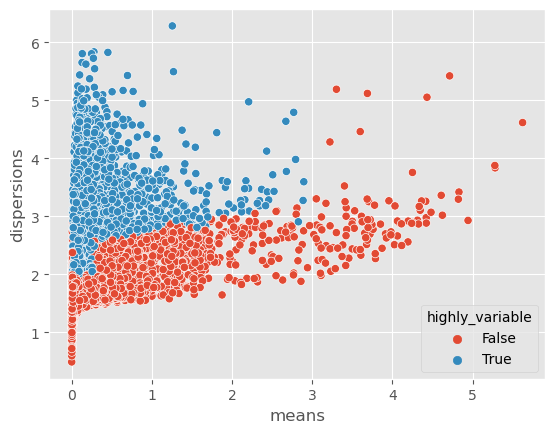

In [223]:
sns.scatterplot(data=df, x="means", y="dispersions", hue="highly_variable")

<AxesSubplot:xlabel='means', ylabel='dispersions_norm'>

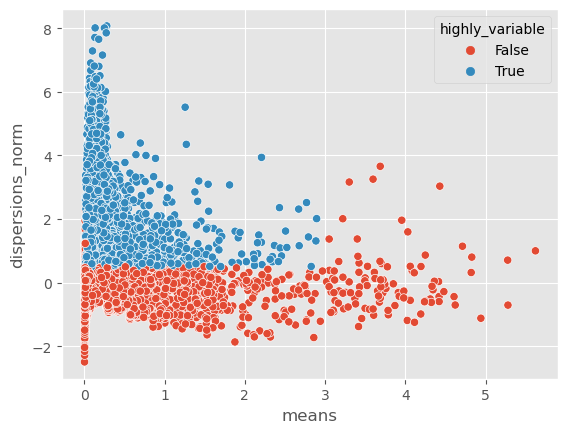

In [225]:
sns.scatterplot(data=df, x="means", y="dispersions_norm", hue="highly_variable")

In [191]:
len(df[df.highly_variable])

4724

In [192]:
adata.shape

(2700, 32738)

In [97]:
disp_grouped, df = highly_variable_genes_single_batch_seurat(adata_filtered_twice_norm_log1plus)

In [185]:
disp_grouped.transform(lambda x: print(len(x)))

10710
1602
638
280
139
100
36
42
31
24
16
20
22
19
13
13
3
3
2
1


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
13709   NaN
13710   NaN
13711   NaN
13712   NaN
13713   NaN
Name: dispersions, Length: 13714, dtype: float64

In [171]:
b

0       -0.988908
1       -1.756099
2       -1.619591
3       -2.170760
4       -0.475737
           ...   
13709   -0.475631
13710    0.516215
13711   -1.067900
13712    0.845314
13713    0.484653
Name: dispersions, Length: 13714, dtype: float64

In [104]:
disp_mean_bin = disp_grouped.mean()
disp_std_bin = disp_grouped.std(ddof=1)

In [105]:
disp_mean_bin

mean_bin
(-0.00562, 0.281]   -2.921602
(0.281, 0.562]      -0.646695
(0.562, 0.843]       0.037674
(0.843, 1.124]       0.528926
(1.124, 1.406]       0.987247
(1.406, 1.687]       1.326801
(1.687, 1.968]       1.646244
(1.968, 2.249]       1.978143
(2.249, 2.53]        2.305950
(2.53, 2.811]        2.626227
(2.811, 3.092]       2.895816
(3.092, 3.373]       3.163694
(3.373, 3.654]       3.475025
(3.654, 3.936]       3.734542
(3.936, 4.217]       4.052018
(4.217, 4.498]       4.342806
(4.498, 4.779]       4.641903
(4.779, 5.06]        4.857354
(5.06, 5.341]        5.275106
(5.341, 5.622]       5.629877
Name: dispersions, dtype: float64

In [106]:
disp_std_bin

mean_bin
(-0.00562, 0.281]    1.387575
(0.281, 0.562]       0.347001
(0.562, 0.843]       0.266681
(0.843, 1.124]       0.175365
(1.124, 1.406]       0.239242
(1.406, 1.687]       0.106211
(1.687, 1.968]       0.099916
(1.968, 2.249]       0.093404
(2.249, 2.53]        0.097774
(2.53, 2.811]        0.095594
(2.811, 3.092]       0.100684
(3.092, 3.373]       0.088935
(3.373, 3.654]       0.088872
(3.654, 3.936]       0.083559
(3.936, 4.217]       0.074962
(4.217, 4.498]       0.080545
(4.498, 4.779]       0.057489
(4.779, 5.06]        0.068264
(5.06, 5.341]        0.001745
(5.341, 5.622]            NaN
Name: dispersions, dtype: float64

In [111]:
one_gene_per_bin = disp_std_bin.isnull()
type(one_gene_per_bin)

pandas.core.series.Series

In [168]:
nan_interval = disp_std_bin.index[disp_std_bin.isnull()]
nan_interval

CategoricalIndex([], categories=[(-0.00562, 0.281], (0.281, 0.562], (0.562, 0.843], (0.843, 1.124], (1.124, 1.406], (1.406, 1.687], (1.687, 1.968], (1.968, 2.249], ...], ordered=True, name='mean_bin', dtype='category')

In [163]:
df.index[df.mean_bin.isin(nan_interval)].tolist()

[7854]

In [166]:
disp_mean_bin[one_gene_per_bin] = 0

In [167]:
disp_std_bin[one_gene_per_bin] = disp_mean_bin[one_gene_per_bin]

In [133]:
disp_std_bin[disp_std_bin == np.nan]

Series([], Name: dispersions, dtype: float64)

In [128]:
type(one_gene_per_bin)

pandas.core.series.Series

In [129]:
one_gene_per_bin.where()

array([19])

In [120]:
one_gene_per_bin[df['mean_bin']]

mean_bin
(-0.00562, 0.281]    False
(-0.00562, 0.281]    False
(-0.00562, 0.281]    False
(-0.00562, 0.281]    False
(-0.00562, 0.281]    False
                     ...  
(-0.00562, 0.281]    False
(0.281, 0.562]       False
(-0.00562, 0.281]    False
(-0.00562, 0.281]    False
(-0.00562, 0.281]    False
Name: dispersions, Length: 13714, dtype: bool

In [121]:
one_gene_per_bin[df['mean_bin'].values]

mean_bin
(-0.00562, 0.281]    False
(-0.00562, 0.281]    False
(-0.00562, 0.281]    False
(-0.00562, 0.281]    False
(-0.00562, 0.281]    False
                     ...  
(-0.00562, 0.281]    False
(0.281, 0.562]       False
(-0.00562, 0.281]    False
(-0.00562, 0.281]    False
(-0.00562, 0.281]    False
Name: dispersions, Length: 13714, dtype: bool

In [113]:
np.where(one_gene_per_bin[df['mean_bin'].values])

(array([7854]),)

In [112]:
one_gene_per_bin

mean_bin
(-0.00562, 0.281]    False
(0.281, 0.562]       False
(0.562, 0.843]       False
(0.843, 1.124]       False
(1.124, 1.406]       False
(1.406, 1.687]       False
(1.687, 1.968]       False
(1.968, 2.249]       False
(2.249, 2.53]        False
(2.53, 2.811]        False
(2.811, 3.092]       False
(3.092, 3.373]       False
(3.373, 3.654]       False
(3.654, 3.936]       False
(3.936, 4.217]       False
(4.217, 4.498]       False
(4.498, 4.779]       False
(4.779, 5.06]        False
(5.06, 5.341]        False
(5.341, 5.622]        True
Name: dispersions, dtype: bool

In [101]:
df[['mean_bin', 'dispersions']]

,mean_bin,dispersions
0,"(-0.00562, 0.281]",-4.293787
1,"(-0.00562, 0.281]",-5.358320
2,"(-0.00562, 0.281]",-5.168906
3,"(-0.00562, 0.281]",-5.933694
4,"(-0.00562, 0.281]",-3.581724
...,...,...
13709,"(-0.00562, 0.281]",-3.581576
13710,"(0.281, 0.562]",-0.467567
13711,"(-0.00562, 0.281]",-4.403393
13712,"(-0.00562, 0.281]",-1.748666


In [58]:
mean, var = my_get_mean_var(adata)

In [ ]:
b = sparse.csr_matrix((3, 4), dtype=np.int8)

In [ ]:
indptr = np.array([0, 2, 3, 6])
indices = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
b = sparse.csr_matrix((data, indices, indptr), shape=(3, 3))

In [ ]:
len(b.indices)

In [ ]:
sparse.issparse(b)

In [ ]:
sparse.issparse([[0]])

In [ ]:
print(adata_filtered_twice_norm[:,1:10])

In [ ]:
print(np.expm1(adata_filtered_twice_norm_log1plus)[:,1:10])